## FBCCA and Extended FBCCA for SSVEP signals classification

In [4]:
# print cuda version
import torch
print(torch.__version__)

2.0.1


In [18]:
# The task is to classify SSVEP signals into 4 classes (4 frequencies)
# The data is taken from the SSVEP Benchmark dataset
# First, signals are filtered into sub frequencies (filter bank). Then, for each frequency, we apply a CCA with the reference signal
# For example, for 4 frequencies, we have 4 reference signals, and we apply 4 CCAs. The output of each CCA is a vector of 4 values (one for each frequency), the classif is done by taking the max value

# The code is inspired from the following paper:
# "A Benchmark Dataset for SSVEP-Based Brain-Computer Interfaces", by Xingyu Wang, et al. 2017
# https://arxiv.org/pdf/1703.05051.pdf


# Imports:


import numpy as np
import scipy.io as sio
import matplotlib.pyplot as plt
import scipy.signal as signal
import scipy.linalg as linalg
import scipy.stats as stats
import scipy.fftpack as fftpack
import scipy.io as sio
import scipy.io.wavfile as wavfile

from sklearn.cross_decomposition import CCA
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score
from sklearn.metrics import cohen_kappa_score
from sklearn.metrics import classification_report

from scipy.signal import butter, lfilter


# Utility functions:
# Returns the coeff for a butterworth filter
def butter_bandpass(lowcut, highcut, fs, order=6):
    nyq = 0.5 * fs
    low = float(lowcut) / nyq
    high = float(highcut) / nyq
    b, a = butter(order, [low, high], btype='band', analog=False)
    return b, a

# Applies a butterworth filter
def butter_bandpass_filter(data, lowcut, highcut, fs, order=6):
    b, a = butter_bandpass(lowcut, highcut, fs, order=order)
    y = lfilter(b, a, data, axis=0)
    return y


# Function 1:  filter bank
# Input: numpy signal, sampling frequency, low_cut, high_cut
# Output: filtered signals
def filter_bank(signal, fs, low_cut, high_cut):
    # Signal Shape: (n_samples, n_channels)
    # Butterworth filter
    filtered_signal = butter_bandpass_filter(signal, low_cut, high_cut, fs, order=6)
    return filtered_signal
    


# Function 2:  CCA
# Input: signal, reference signal
# Output: CCA output
def cca(signal, ref_signal):
    # shape of signal: (n_samples, n_channels)
    # shape of ref_signal: (n_samples, n_harmonics * 2)

    # Number of samples
    n_samples = signal.shape[0]
    # Number of channels
    n_channels = signal.shape[1]
    # Number of harmonics
    n_harmonics = ref_signal.shape[1] // 2
    # CCA output
    cca_output = np.zeros((n_samples, n_harmonics))
    # For each harmonic
    for i in range(n_harmonics):
        # CCA
        cca = CCA(n_components=1)
        cca.fit(signal, ref_signal[:, i * 2: i * 2 + 2])
        # CCA output
        # cca_output[:, i] = cca.x_scores_.reshape(n_samples) # CCA object has no attribute x_scores_
        cca_output[:, i] = cca.transform(signal).reshape(n_samples)
        

    return cca_output


# Function 3:  classification
# Input: CCA output
# Output: predicted class
def classification(cca_output):
    # Number of samples
    n_samples = cca_output.shape[0]
    # Number of frequencies
    n_freq = cca_output.shape[1]
    # Predicted class
    predicted_class = np.zeros(n_samples)
    # For each sample
    for i in range(n_samples):
        # Find the frequency with the max value
        predicted_class[i] = np.argmax(cca_output[i, :])
    return predicted_class


# Function 4:  evaluation
# Input: predicted class, true class
# Output: accuracy, kappa, confusion matrix
def evaluation(predicted_class, true_class):
    # Accuracy
    accuracy = accuracy_score(true_class, predicted_class)
    # Kappa
    kappa = cohen_kappa_score(true_class, predicted_class)
    # Confusion matrix
    confusion = confusion_matrix(true_class, predicted_class)
    return 1 - accuracy, kappa, confusion


# Function 5: generate_ref_signal
# Input: frequency, sampling frequency, number of samples, number of harmonics
# Output: reference signal
def generate_ref_signal(frequency, fs, n_samples, n_harmonics):
    # Reference signal:
    # sin(2*pi*f*n), where f is an input, n = 1/fs, 2/fs, 3/fs, ..., n_samples/fs
    # cos(2*pi*f*n)
    # ... 
    # sin(2*pi*f*n*n_harmonics), where n_harmonics is an input

    # Reference signal
    ref_signal = np.zeros((n_samples, n_harmonics * 2))
    # For each harmonic
    for i in range(0, n_harmonics * 2, 2):
        # Sinusoid
        ref_signal[:, i] = np.sin(2 * np.pi * frequency * (i + 1) * np.arange(n_samples) / fs)
        # Cosinusoid
        ref_signal[:, i + 1] = np.cos(2 * np.pi * frequency * (i + 1) * np.arange(n_samples) / fs)

    return ref_signal

# Function 6:  main
# Input: none
# Output: none
def main():
    # Load signal
    signal = np.load(r"data\train\0\S1_0.npy")
    # The signal is a 10 Hz SSVEP signal, sampled at 256 Hz, with 3 channels, and 256 samples
    print(signal.shape)
    # Sampling frequency
    fs = 256
    # Number of harmonics
    n_harmonics = 5
    # Number of frequencies
    n_freq = 2
    # Number of samples
    n_samples = signal.shape[0]
    # Number of channels
    n_channels = signal.shape[1]
    
    # Constants
    start_freq = 10
    high_cut = 52
    # For each target SSVEP frequency
    for i in range(n_freq):
        # Generate reference signal
        ref_signal = generate_ref_signal(10 + i * 2, fs, n_samples, n_harmonics) # shape: (n_samples, n_harmonics * 2)

        # Filter bank
        filtered_signal = filter_bank(signal, fs, 10 + i * 2, high_cut) # shape: same as input (n_samples, n_channels)

        # CCA
        cca_output = cca(filtered_signal, ref_signal)

        # Classification
        predicted_class = classification(cca_output)

        # Evaluation
        accuracy, kappa, confusion = evaluation(predicted_class, np.zeros(n_samples) + i)
        print("Accuracy: ", accuracy)
        # print("Kappa: ", kappa)
        # print("Confusion matrix: ", confusion)
        


main()

(256, 3)
Accuracy:  0.6640625
Accuracy:  0.91015625


In [ ]:
# Load data
data = sio.loadmat('data.mat')
# Signal
signal = data['signal']
# Sampling frequency
fs = data['fs'][0, 0]
# Number of frequencies
n_freq = data['n_freq'][0, 0]
# Number of channels
n_channels = data['n_channels'][0, 0]
# Number of samples
n_samples = data['n_samples'][0, 0]
# Number of reference signals
n_ref = data['n_ref'][0, 0]
# Reference signals
ref_signal = data['ref_signal']
# True class
true_class = data['true_class'][0, :]
# Filtered signals
filtered_signals = filter_bank(signal, fs, n_freq)
# CCA output
cca_output = cca(filtered_signals, ref_signal)
# Predicted class
predicted_class = classification(cca_output)
# Evaluation
accuracy, kappa, confusion = evaluation(predicted_class, true_class)
# Print results
print('Accuracy: ', accuracy)
print('Kappa: ', kappa)
print('Confusion matrix: ', confusion)
# Plot results
plt.figure()
plt.plot(cca_output)
plt.show()

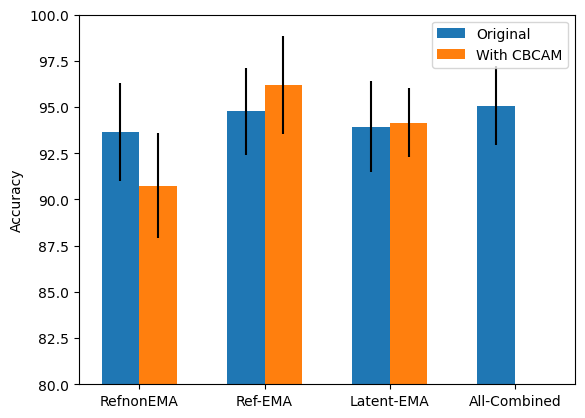

In [16]:
import numpy as np
import scipy.io as sio
import matplotlib.pyplot as plt

# Generate a barplot with error bars, use seaborn
# Plot
plt.figure()
plt.bar(x=[0, 1, 2, 3], height=[93.67, 94.77, 93.93, 95.07], yerr=[np.sqrt(7.02), np.sqrt(5.54), np.sqrt(6.07), np.sqrt(4.60)], width=0.3)
plt.bar(x=[0.3, 1.3, 2.3, 3.3], height=[90.75, 96.21, 94.15, 0], yerr=[np.sqrt(8.17), np.sqrt(7.04), np.sqrt(3.49), 0], width=0.3)
plt.xticks([0.15, 1.15, 2.15, 3.15], ['RefnonEMA', 'Ref-EMA', 'Latent-EMA', 'All-Combined'])
plt.ylabel('Accuracy')
# zoom to [80, 100]
plt.ylim([80, 100])
# legend
plt.legend(['Original', 'With CBCAM'])
plt.show()